In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm

from gtfparse import read_gtf
import anndata

from config import FDIR_EXTERNAL, FDIR_INTEMEDIATE, FDIR_PROCESSED, FDIR_RAW, PROJ_ROOT


In [2]:

fdir_raw = FDIR_RAW
fdir_intermediate = FDIR_INTEMEDIATE
fdir_processed = FDIR_PROCESSED / "sex"
fdir_external = FDIR_EXTERNAL
ml_models_fdir = PROJ_ROOT/"models"


use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


value_to_predict = 'sex'

organ_names = {
    "BRAIN0": "BRAIN0",
    "HEART": "HEART",
    "BRAIN1": "BRAIN1",
    "None": "BLOOD",
    "CAGE.HEART": "CAGE.HEART",
}

filename_prefixes = {
    "None": "geuvadis",
    "CAGE.HEART": "CAGE.HEART",
    "BRAIN0": "BRAIN0",
    "HEART": "HEART",
    "BRAIN1": "BRAIN1",
}


In [42]:
def read_geuvadis(fname_data: Path | str,
                  fname_header: Path | str,
                  fname_gtf: Path | str):
    data_raw = pd.read_csv(fname_data, index_col=0).T
    data_raw = data_raw.astype(np.float32)

    data_header = pd.read_csv(fname_header, index_col=0)

    gtf_rawdata = read_gtf(fname_gtf)
    gtf_data = gtf_rawdata.to_pandas()
    gtf_data = gtf_data.set_index('transcript_id')
    gtf_data['transcript_id'] = gtf_data.index

    gtf_data = gtf_data.drop_duplicates("transcript_id")

    print('Dataset shape: ', data_raw.shape)

    return data_raw, data_header, gtf_data

data_raw, data_header, gtf_data = read_geuvadis(
    fdir_raw / 'Geuvadis.all.csv',
    fdir_raw / 'Geuvadis.SraRunTable.txt',
    fdir_raw / 'all_transcripts_strigtie_merged.gtf'
)

# data_raw = data_raw[data_raw.columns.intersection(gtf_data.index)]
# gtf_data = gtf_data.loc[data_raw.columns.intersection(gtf_data.index)]

# adata = anndata.AnnData(data_raw)
# adata.var = gtf_data
# adata.obs = data_header

# adata

adata = anndata.read_h5ad(fdir_processed / f"GEUVADIS.preprocessed.{value_to_predict}.h5ad")

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


Dataset shape:  (667, 338725)


In [44]:
fdir_raw

PosixPath('/home/arsenii/Documents/PYTHON/RNASeqAnalysis/data/raw')

In [43]:
gtf_data

,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
transcript_id,,,,,,,,,,,,,
MSTRG.1.1,GL000008.2,StringTie,transcript,1,17013,1000.0,NaN,0,MSTRG.1,,,,MSTRG.1.1
MSTRG.2.1,GL000008.2,StringTie,transcript,199413,199638,1000.0,NaN,0,MSTRG.2,,,,MSTRG.2.1
MSTRG.3.1,GL000009.2,StringTie,transcript,60101,61775,1000.0,NaN,0,MSTRG.3,,,,MSTRG.3.1
MSTRG.4.1,GL000194.1,StringTie,transcript,53528,112911,1000.0,NaN,0,MSTRG.4,,,,MSTRG.4.1
MSTRG.5.1,GL000195.1,StringTie,transcript,42917,56806,1000.0,NaN,0,MSTRG.5,,,,MSTRG.5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000456738.1,chrY,HAVANA,transcript,26586642,26591601,NaN,-,0,ENSG00000227629.1,,SLC25A15P1,ENSG00000227629.1,ENST00000456738.1
ENST00000711258.1,chrY,HAVANA,transcript,57015105,57016096,NaN,-,0,ENSG00000292364.1,,AMD1P2,ENSG00000292364.1,ENST00000711258.1
ENST00000711259.1,chrY,HAVANA,transcript,57062156,57062405,NaN,+,0,ENSG00000292365.1,,DPH3P2,ENSG00000292365.1,ENST00000711259.1


In [4]:
transcripts_dict = {}
transcripts_list = []
for organ_name in ['BRAIN0', "HEART", "BRAIN1", 'None']:
    
    organ = filename_prefixes[organ_name]
    # if organ_name == "None":
    #     organ = "BLOOD"
    # else:
    #     organ = organ_name
    
    transcripts_dict[organ_names[organ_name]] = {}

    for sex in ['chr_aXY', 'chr_aX', 'chr_aY', 'autosomes']:
        features_fname = (
            f"{organ}_train_features_{sex}_calibration_{organ_name}.csv"
        )
        features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)
        
        transcripts_dict[organ_names[organ_name]][sex] = features_list.index.to_list()
        
        transcripts_list.extend(features_list.index.tolist())
        # print(features_list)
transcripts_list = list(set(transcripts_list))

In [5]:
transcripts_dict.keys()

dict_keys(['BRAIN0', 'HEART', 'BRAIN1', 'BLOOD'])

In [6]:
# features_fname = f"geuvadis_train_features_{'chr_aY'}_calibration_{'None'}.csv"
# features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)
# print(ml_models_fdir / model_type / features_fname)
# features_list

In [7]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

# example = generate_counts()
# plot(example)
# example

In [8]:
import itertools
import pprint

for organ in ['BRAIN0', "HEART", "BRAIN1", 'BLOOD']:
    transcripts_dict[organ]['chr_aXY']

# for key1, key2 in list(itertools.combinations(['BRAIN0', "HEART", "BRAIN1", 'None'], 2)):
#     transcripts_dict[key1]['chrXY'].union(transcripts_dict[key2]['chrXY'])
pprint.pprint(transcripts_dict, width=120)
# 

{'BLOOD': {'autosomes': ['ENST00000382545.5',
                         'ENST00000540597.5',
                         'MSTRG.1913.3',
                         'ENST00000409140.8',
                         'ENST00000372476.8',
                         'ENST00000368680.4',
                         'ENST00000413366.8',
                         'ENST00000468138.5',
                         'ENST00000302177.3',
                         'ENST00000300184.8',
                         'MSTRG.34956.17',
                         'ENST00000521488.1',
                         'ENST00000543727.5',
                         'ENST00000581584.5',
                         'ENST00000477689.2',
                         'ENST00000360428.9',
                         'MSTRG.22933.7',
                         'MSTRG.32063.17',
                         'MSTRG.21797.4',
                         'MSTRG.21438.5',
                         'ENST00000472755.2',
                         'MSTRG.5695.28',
               

In [9]:
transcripts_dict['HEART']['chr_aY']



['ENST00000361365.7',
 'MSTRG.36786.4',
 'MSTRG.36809.22',
 'MSTRG.36790.14',
 'ENST00000485584.1',
 'MSTRG.36713.13',
 'MSTRG.36835.1',
 'ENST00000529180.1',
 'ENST00000416274.7',
 'MSTRG.5794.10',
 'MSTRG.15817.15',
 'MSTRG.28898.5',
 'MSTRG.5833.3',
 'ENST00000555818.5',
 'MSTRG.4871.10',
 'ENST00000360428.9',
 'ENST00000496760.5',
 'ENST00000390331.3',
 'MSTRG.1806.49',
 'ENST00000564400.5',
 'ENST00000379550.5',
 'MSTRG.11059.17',
 'ENST00000465421.5',
 'MSTRG.23006.1',
 'ENST00000440400.3',
 'MSTRG.1402.3',
 'MSTRG.28976.5',
 'ENST00000489672.5',
 'ENST00000588869.1',
 'ENST00000440934.2',
 'ENST00000676544.1',
 'MSTRG.12760.3',
 'MSTRG.34200.15',
 'MSTRG.34128.6',
 'ENST00000548180.5',
 'ENST00000291839.10',
 'MSTRG.8797.23',
 'ENST00000556018.5',
 'MSTRG.251.5',
 'ENST00000373146.6',
 'MSTRG.18657.3',
 'MSTRG.13212.2',
 'MSTRG.8681.5',
 'MSTRG.25424.1',
 'ENST00000650811.1',
 'MSTRG.21155.3',
 'MSTRG.27857.1',
 'MSTRG.15884.2',
 'ENST00000650026.1',
 'ENST00000319234.5']

In [10]:
print(adata.var.loc[transcripts_dict['HEART']['chr_aY']]['seqname'].unique())

organ = "HEART"
value_to_predict = "sex"
# adata_eval = anndata.read_h5ad(
#     fdir_processed / f"{filename_prefixes[organ]}.preprocessed.{value_to_predict}.h5ad"
# )

adata_eval = anndata.read_h5ad(FDIR_INTEMEDIATE / f"{filename_prefixes[organ]}.raw.h5ad")

np.where(adata_eval.var['seqname'] == 'chrY')

['chrY', 'chr11', 'chr8', 'chr17', 'chr6', ..., 'chr7', 'chr2', 'chr3', 'chr12', 'chr5']
Length: 20
Categories (28, object): ['GL000224.1', 'KI270442.1', 'KI270726.1', 'KI270728.1', ..., 'chr8', 'chr7', 'chrX', 'chrY']


(array([   173,    446,   2220, ..., 356158, 356159, 356160]),)

In [11]:
# pd.DataFrame.from_dict(transcripts_dict)

# with pd.ExcelWriter("/home/arsenii/Documents/PYTHON/RNASeqAnalysis/reports/for_paper/transcripts.xlsx") as writer:
#     for tissue, categories in transcripts_dict.items():
#         dfs = []
#         for category, features in categories.items():
#             df = pd.DataFrame({'Feature': features})
#             df['Category'] = category
#             dfs.append(df)
#         tissue_df = pd.concat(dfs, ignore_index=True)
#         tissue_df.to_excel(writer, sheet_name=tissue, index=False)

In [14]:
# test_dict['train: BLOOD, test: BRAIN0']

Chromosomes:  chr_aX
['train: BLOOD, test: HEART' 'train: BLOOD, test: BRAIN1'
 'train: BLOOD, test: BLOOD'] : 
{'MSTRG.24071.9', 'ENST00000358395.11', 'ENST00000647913.2', 'ENST00000395951.7', 'MSTRG.14189.5', 'ENST00000620525.1', 'MSTRG.7480.16', 'ENST00000548171.1', 'MSTRG.19853.4', 'ENST00000307259.9'}
['train: BLOOD, test: HEART' 'train: BLOOD, test: BRAIN1'] : 
{'ENST00000382899.9', 'ENST00000647441.1', 'MSTRG.1559.106', 'ENST00000529768.5'}
['train: BLOOD, test: BRAIN1'] : 
{'MSTRG.26738.5', 'MSTRG.30522.25', 'ENST00000427928.1', 'ENST00000361444.3', 'MSTRG.15957.1', 'MSTRG.29296.59', 'ENST00000545631.2', 'MSTRG.4878.5', 'ENST00000486860.5', 'MSTRG.25255.27', 'MSTRG.10526.12', 'MSTRG.11438.3', 'MSTRG.18967.1', 'ENST00000605833.2', 'ENST00000638094.1', 'MSTRG.15653.10', 'ENST00000428017.5', 'ENST00000621129.5', 'ENST00000438261.5', 'ENST00000397311.4', 'MSTRG.9001.10', 'MSTRG.21762.26', 'ENST00000482437.5', 'MSTRG.1964.2', 'MSTRG.28171.3', 'ENST00000567391.5'}
['train: BLOOD, tes

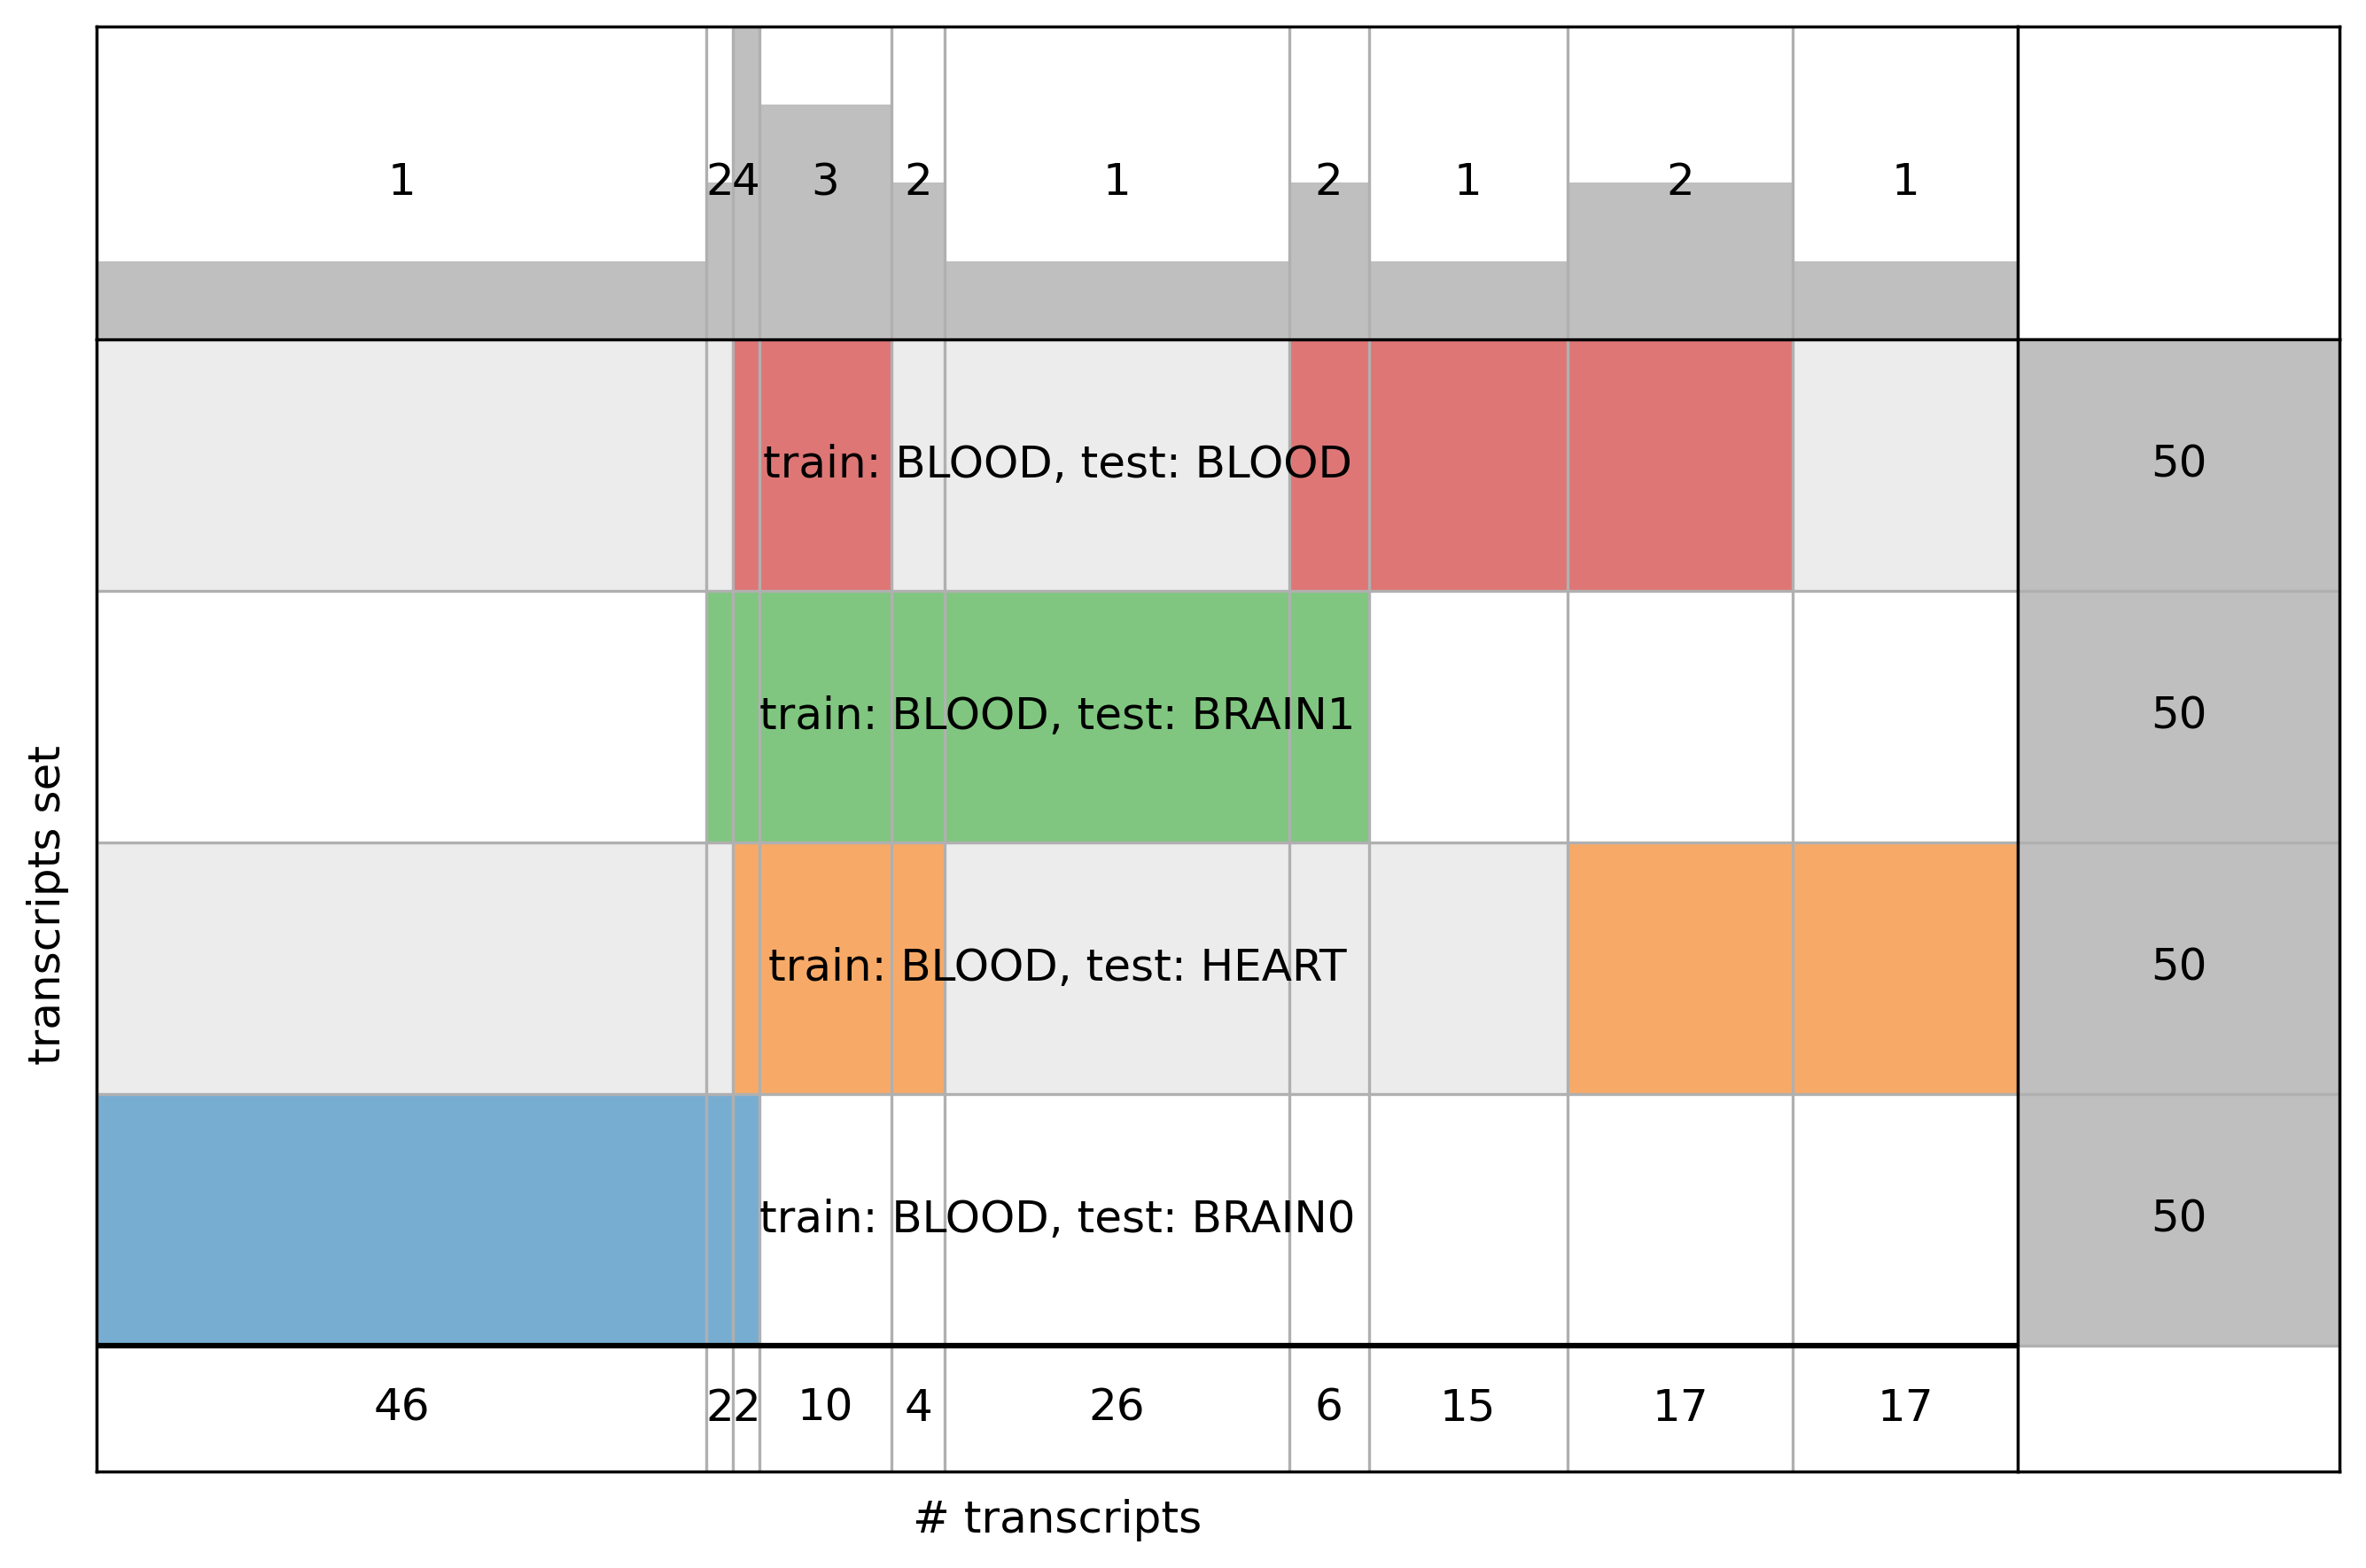

In [15]:
# chrXY_df = {
#     # "names": transcripts_list,
#     'BRAIN0': [],
#     'HEART': [], 
#     'BRAIN1': [],
#     'None': []
#     }
# fig, axs= plt.subplots()
# for transcript in transcripts_list:
#     for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
        
#         if transcript in transcripts_dict[organ]['chrXY']:
#             chrXY_df[organ].append(True)
#         else:
#             chrXY_df[organ].append(False)
# chrXY_df = pd.DataFrame.from_dict(chrXY_df)
# 
# UpSet(chrXY_df, subset_size='count').plot()

# for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:

row_names = {
    "BRAIN0": "train: BLOOD, test: BRAIN0", 
    "HEART": "train: BLOOD, test: HEART", 
    "BRAIN1": "train: BLOOD, test: BRAIN1", 
    "BLOOD": "train: BLOOD, test: BLOOD",
}

sex = ['chr_aXY', 'chr_aX', 'chr_aY', 'autosomes'][1]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1", 'BLOOD']:
    test_dict[row_names[organ]] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        # side_plots=False
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('transcripts set')


print("Chromosomes: ", sex)

membership = []
memb_data = []

for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])

    membership.append((np.array(list(test_dict.keys()))[list(el)]).tolist())
    memb_data.append(len(g.chunks[el]))

In [36]:

adata.var

,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
ENST00000003912.7,chr1,StringTie,transcript,24415803,24473468,1000.0,+,0,MSTRG.676,,NIPAL3,ENSG00000001461.17,ENST00000003912.7
ENST00000005260.9,chr7,StringTie,transcript,98291650,98401194,1000.0,-,0,MSTRG.31712,,BAIAP2L1,ENSG00000006453.14,ENST00000005260.9
ENST00000008180.13,chr16,StringTie,transcript,3065631,3070561,1000.0,+,0,MSTRG.12620,,IL32,ENSG00000008517.19,ENST00000008180.13
ENST00000013034.3,chr17,StringTie,transcript,51153665,51162428,1000.0,+,0,MSTRG.15436,,NME1,ENSG00000239672.8,ENST00000013034.3
ENST00000014935.7,chrX,StringTie,transcript,154401758,154410306,1000.0,-,0,MSTRG.36629,,DNASE1L1,ENSG00000013563.14,ENST00000014935.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSTRG.9968.1,chr14,StringTie,transcript,30622137,30737694,1000.0,+,0,MSTRG.9968,,,,MSTRG.9968.1
MSTRG.9981.8,chr14,StringTie,transcript,32077227,32159743,1000.0,+,0,MSTRG.9981,,,,MSTRG.9981.8
MSTRG.9995.1,chr14,StringTie,transcript,30874043,30885621,1000.0,+,0,MSTRG.9995,,,,MSTRG.9995.1
MSTRG.9995.3,chr14,StringTie,transcript,30874407,30891080,1000.0,+,0,MSTRG.9995,,,,MSTRG.9995.3


In [40]:
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)].tolist(), ": ")
    print(adata.var.loc[list(g.chunks[el]), 'transcript_id'].unique().tolist())
    print("\n")

['train: BLOOD, test: HEART', 'train: BLOOD, test: BRAIN1', 'train: BLOOD, test: BLOOD'] : 
['MSTRG.24071.9', 'ENST00000358395.11', 'ENST00000647913.2', 'ENST00000395951.7', 'MSTRG.14189.5', 'ENST00000620525.1', 'MSTRG.7480.16', 'ENST00000548171.1', 'MSTRG.19853.4', 'ENST00000307259.9']


['train: BLOOD, test: HEART', 'train: BLOOD, test: BRAIN1'] : 
['ENST00000382899.9', 'ENST00000647441.1', 'MSTRG.1559.106', 'ENST00000529768.5']


['train: BLOOD, test: BRAIN1'] : 
['MSTRG.26738.5', 'MSTRG.30522.25', 'ENST00000427928.1', 'ENST00000361444.3', 'MSTRG.15957.1', 'MSTRG.29296.59', 'ENST00000545631.2', 'MSTRG.4878.5', 'ENST00000486860.5', 'MSTRG.25255.27', 'MSTRG.10526.12', 'MSTRG.11438.3', 'MSTRG.18967.1', 'ENST00000605833.2', 'ENST00000638094.1', 'MSTRG.15653.10', 'ENST00000428017.5', 'ENST00000621129.5', 'ENST00000438261.5', 'ENST00000397311.4', 'MSTRG.9001.10', 'MSTRG.21762.26', 'ENST00000482437.5', 'MSTRG.1964.2', 'MSTRG.28171.3', 'ENST00000567391.5']


['train: BLOOD, test: BRAIN0', '

In [106]:
adata.var.loc[list(g.chunks[el]), 'transcript_id'].unique().tolist()
# gtf_data.loc[adata.var.loc[list(g.chunks[el]), 'transcript_id'].unique().tolist(), ['start']]

['MSTRG.17108.17',
 'MSTRG.4214.3',
 'MSTRG.31018.6',
 'MSTRG.2401.8',
 'MSTRG.36020.28',
 'ENST00000493987.5']

In [101]:
for tr_id in adata.var.loc[list(g.chunks[el]), 'transcript_id'].unique().tolist():
    criterion = (gtf_data['end'] <= gtf_data.loc[[tr_id], ['end']].values[0][0]) & (gtf_data['start'] >= gtf_data.loc[[tr_id], ['start']].values[0][0])
    seqname = gtf_data.loc[[tr_id], ['seqname']].values[0][0]
    print(tr_id)
    print(gtf_data.loc[criterion & (gtf_data['seqname'] == seqname), 'gene_name'].unique())
    print("-"*50)

MSTRG.17108.17
['' 'MARCHF2' 'HNRNPM' 'ENSG00000268931' 'ENSG00000279827']
--------------------------------------------------
MSTRG.4214.3
['' 'SNORA74C-1']
--------------------------------------------------
MSTRG.31018.6
['' 'SKAP2']
--------------------------------------------------
MSTRG.2401.8
['' 'SLC50A1']
--------------------------------------------------
MSTRG.36020.28
['' 'XIST' 'ENSG00000291306' 'ENSG00000277577' 'ENSG00000278039']
--------------------------------------------------
ENST00000493987.5
['TPI1']
--------------------------------------------------


/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles[

Text(0.5, 1.0, 'autosomes')

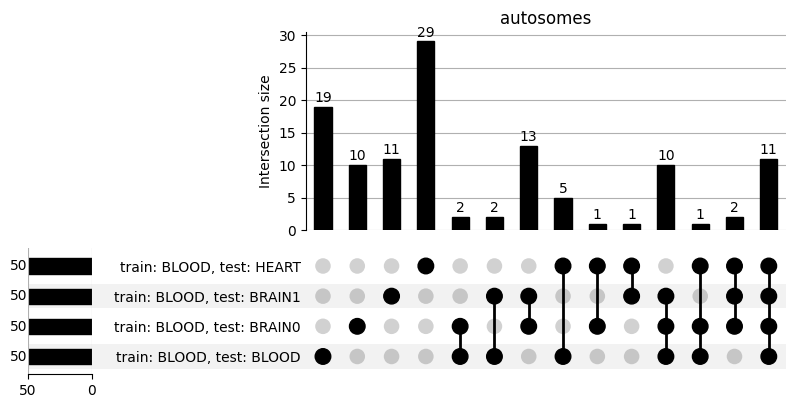

In [26]:
from upsetplot import from_memberships, plot

chr_names = {
    'chr_aXY': "chr_aXY" , 
    'chr_aX': "chr_aX" , 
    'chr_aY': "chr_aY" , 
    'autosomes': "autosomes" 
}

example = from_memberships(membership, data=memb_data)
plot(example, show_counts=True)
plt.title(chr_names[sex])

In [27]:
organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][0]
test_dict = {}
for sex in ['chr_aXY', 'chr_aX', 'chr_aY', 'autosomes']:
    test_dict[sex] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])

AttributeError: 'list' object has no attribute 'tolist'

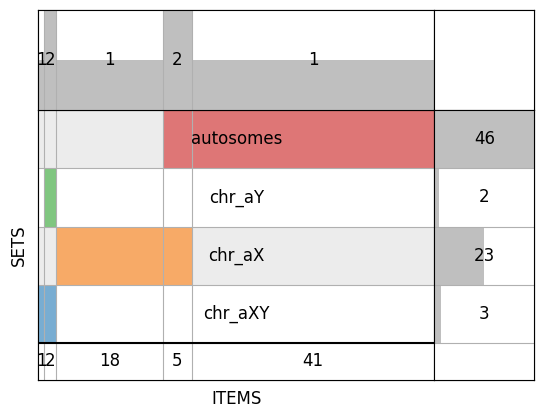

In [ ]:
g = supervenn(list(test_dict.values()), list(test_dict.keys()), 
              sets_ordering=None)

In [65]:
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)])

['autosomes']
['chr_aX']
['chr_aXY' 'chr_aY']
['chr_aX' 'autosomes']
['chr_aXY']


In [60]:
np.array(list(test_dict.keys()))

array(['chr_aXY', 'chr_aX', 'chr_aY', 'autosomes'], dtype='<U9')